In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

os.chdir('/data/eeh55/Github/GausSN/py/')
import gausSN
import kernels
import meanfuncs
import lensingmodels
os.chdir('../ipynb')

plt.style.use('./stylesheet/GausSN.mplstyle')

In [20]:
def logprior(kernel_params=None, meanfunc_params=None):
    if True:
        return 0
    return -np.inf

def ptform(u):
    prior = u
    prior[0] = (u[0] * 45) + 5
    prior[1] = (u[1] * 30) + 10
    prior[2] = (u[2] * 60) + 1
    prior[3] = (u[3] * 0.9) + 0.1
    return(prior)
    
def fit_lensedSN(snid, data, show_plots=False):
    output_dict = {}
    
    im_ids = np.unique(data['image'])
    pb_ids = np.unique(data['band'])
    
    for j, pb_id in enumerate(pb_ids):
        band = data[data['band'] == pb_id]
        for i, im_id in enumerate(im_ids):
            if i == 0 and j == 0:
                xdat = band[band['image'] == im_id]['time']
                ydat = band[band['image'] == im_id]['flux']
                yerrdat = band[band['image'] == im_id]['fluxerr']
            else:
                xdat = np.concatenate([xdat, band[band['image'] == im_id]['time'].value])
                ydat = np.concatenate([ydat, band[band['image'] == im_id]['flux'].value])
                yerrdat = np.concatenate([yerrdat, band[band['image'] == im_id]['fluxerr'].value])
                

    meanfunc_params = [0]
    meanfunc = meanfuncs.UniformMean(meanfunc_params)
    kernel = kernels.ExpSquaredKernel([30, 20])
    gp = gausSN.GP(kernel, meanfunc)
        
    lm = lensingmodels.LensingModel([10, 0.5], len(im_ids), len(pb_ids))
    sampler = gp.optimize_parameters(x = xdat, y = ydat, yerr = yerrdat, n_bands = len(pb_ids),
                                     method='nested_sampling', ptform=ptform, lensing_model = lm,
                                     logprior=logprior, fix_mean_params=True)
    
    if show_plots:
        plt.figure()
        param_names = ['A', 'tau']
        param_names = param_names + (['delta', 'beta'] * (len(im_ids)-1))
        fig, ax = dyplot.cornerplot(sampler.results, show_titles=True, labels=param_names)
        plt.show()
        plt.clf()
        plt.figure()
        fig, axes = dyplot.traceplot(sampler.results, show_titles=True, labels=param_names)
        fig.tight_layout()
        plt.show()
        plt.clf()
    
    return sampler

In [21]:
glSN_path = '../output_files/glSN_forGP_sims/'
files = [glSN_path+fn for fn in os.listdir(glSN_path) if fn.endswith('.csv')]

5866it [04:37, 21.12it/s, +500 | bound: 22 | nc: 1 | ncall: 168419 | eff(%):  3.791 | loglstar:   -inf < -376.268 <    inf | logz: -387.279 +/-  0.148 | dlogz:  0.001 >  0.509]


<Figure size 640x480 with 0 Axes>

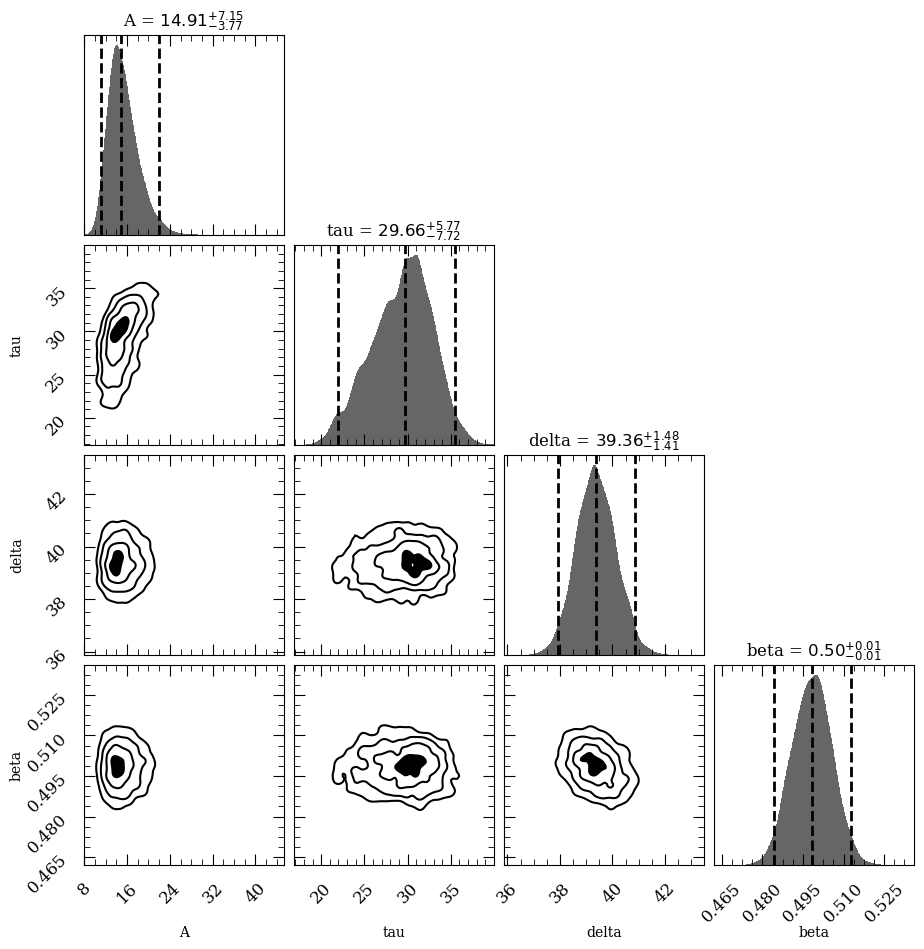

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

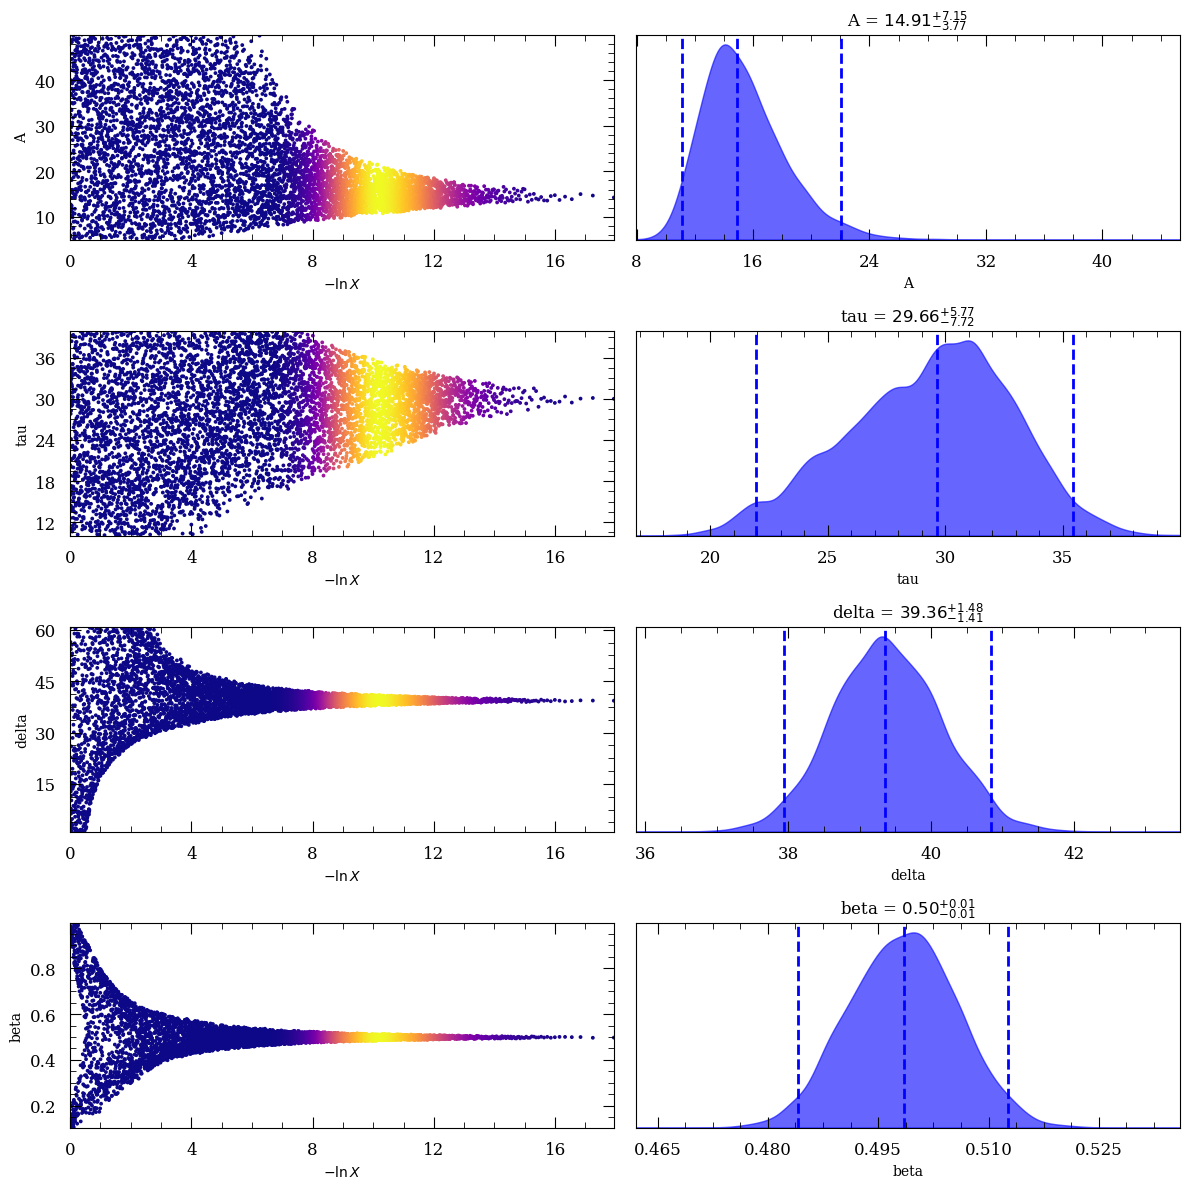

<Figure size 640x480 with 0 Axes>

In [22]:
fn = files[10]

snid = fn.split('/')[-1].split('.')[0]
data = ascii.read(fn)
    
sampler = fit_lensedSN(snid, data, show_plots=True)
    
mean, cov = dyfunc.mean_and_cov(sampler.results.samples, sampler.results.importance_weights())

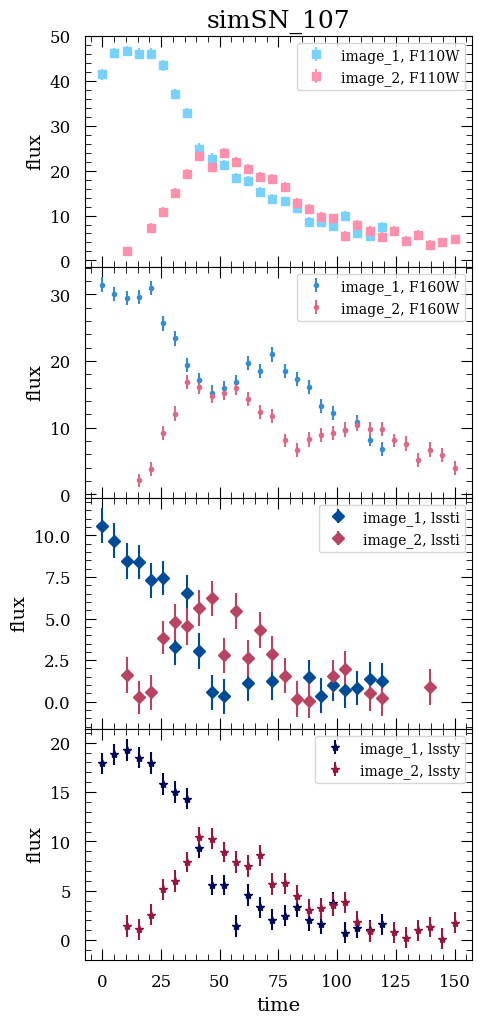

In [28]:
colors = [['#77d2ff', '#338dce', '#004b97', '#000958'], ['#ff90ae', '#dc6a87', '#b94461', '#95193e']]
markers = ['s', '.', 'D', '*']

fig, ax = plt.subplots(len(np.unique(data['band'])), 1, figsize=(5,12), sharex=True)

for b, pb_id in enumerate(np.unique(data['band'])):
    band = data[data['band'] == pb_id]
    
    for m, im_id in enumerate(np.unique(data['image'])):
        image = band[band['image'] == im_id]
        
        ax[b].errorbar(image['time'], image['flux'], yerr=image['fluxerr'], ls='None', marker=markers[b],
                       color=colors[m][b], label=f"{im_id}, {pb_id}")
        ax[b].legend()
        ax[b].set_ylabel('flux', fontsize=14)
        

ax[3].set_xlabel('time', fontsize=14)
ax[0].set_title(snid, fontsize=18)
plt.subplots_adjust(hspace=0)

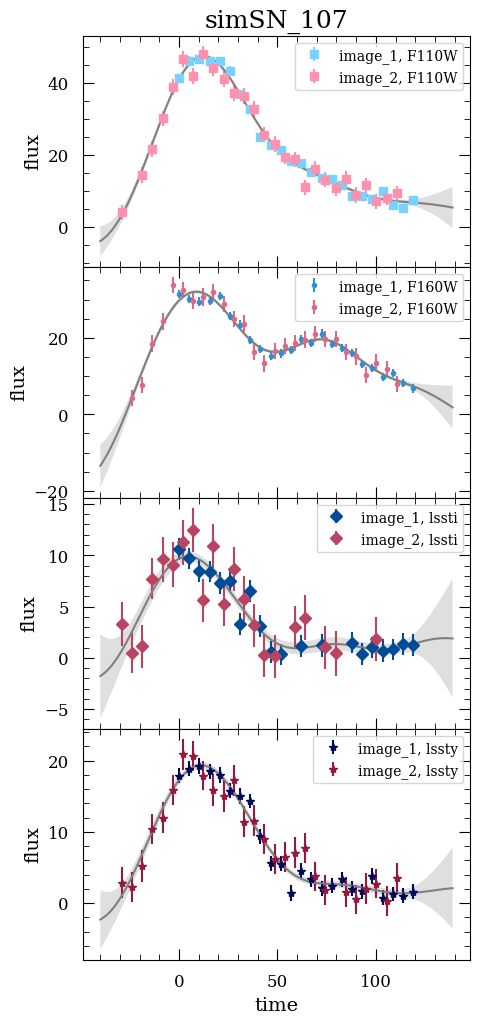

In [34]:
times = np.arange(-40, 140, 1)
meanfunc = meanfuncs.UniformMean([0])
kernel = kernels.ExpSquaredKernel([mean[0], mean[1]])
gp = gausSN.GP(kernel, meanfunc)

fig, ax = plt.subplots(len(np.unique(data['band'])), 1, figsize=(5,12), sharex=True)

for b, pb_id in enumerate(np.unique(data['band'])):
    band = data[data['band'] == pb_id]
    
    stacked_x = []
    stacked_y = []
    stacked_yerr = []
    
    for m, im_id in enumerate(np.unique(data['image'])):
        image = band[band['image'] == im_id]
        
        if im_id == 'image_2':
            ax[b].errorbar(image['time']-mean[2], image['flux']/mean[3], yerr=image['fluxerr']/mean[3], ls='None',
                           marker=markers[b], color=colors[m][b], label=f"{im_id}, {pb_id}")
            stacked_x = stacked_x + list(image['time']-mean[2])
            stacked_y = stacked_y + list(image['flux']/mean[3])
            stacked_yerr = stacked_yerr + list(image['fluxerr']/mean[3])
        
        else:
            ax[b].errorbar(image['time'], image['flux'], yerr=image['fluxerr'], ls='None', marker=markers[b],
                           color=colors[m][b], label=f"{im_id}, {pb_id}")
            stacked_x = stacked_x + list(image['time'])
            stacked_y = stacked_y + list(image['flux'])
            stacked_yerr = stacked_yerr + list(image['fluxerr'])
            
        ax[b].legend()
        ax[b].set_ylabel('flux', fontsize=14)
    
    exp, cov = gp.predict(times, np.array(stacked_x), np.array(stacked_y), np.array(stacked_yerr))
    ax[b].plot(times, exp, color='gray')
    ax[b].fill_between(times, exp-np.sqrt(np.diag(cov)), exp + np.sqrt(np.diag(cov)), color='gray', alpha=0.25,
                       edgecolor='None')
        

ax[3].set_xlabel('time', fontsize=14)
ax[0].set_title(snid, fontsize=18)
plt.subplots_adjust(hspace=0)